In [142]:
import os, sys
os.chdir('C:\\Users\\Ben\\Documents\\682_project')
import torch
from torch.functional import F
import pandas as pd
import pickle
from models.draft_bert import *
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import *
from sklearn.cluster import *
%matplotlib inline

In [106]:
pd.set_option('display.max_rows', 1000)

In [26]:
with open('data/draft_pretrain.pkl', 'rb') as f:
    data = pickle.load(f)
with open('data/draft_pretrain_le.pkl', 'rb') as f:
    le = pickle.load(f)

In [32]:
hero_ids = pd.read_json('const/hero_ids.json', orient='records')
hero_ids = hero_ids.set_index('id')
hero_ids['id'] = hero_ids.index
hero_ids['embed_idx'] = hero_ids['id'].apply(lambda x: le.transform([[x]][0])[0])
hero_ids = hero_ids.sort_values('embed_idx')

In [33]:
hero_ids

,name,localized_name,primary_attr,attack_type,roles,legs,id,embed_idx
id,,,,,,,,
1,npc_dota_hero_antimage,Anti-Mage,agi,Melee,"[Carry, Escape, Nuker]",2,1,0
2,npc_dota_hero_axe,Axe,str,Melee,"[Initiator, Durable, Disabler, Jungler]",2,2,1
3,npc_dota_hero_bane,Bane,int,Ranged,"[Support, Disabler, Nuker, Durable]",4,3,2
4,npc_dota_hero_bloodseeker,Bloodseeker,agi,Melee,"[Carry, Disabler, Jungler, Nuker, Initiator]",2,4,3
5,npc_dota_hero_crystal_maiden,Crystal Maiden,int,Ranged,"[Support, Disabler, Nuker, Jungler]",2,5,4
...,...,...,...,...,...,...,...,...
114,npc_dota_hero_monkey_king,Monkey King,agi,Melee,"[Carry, Escape, Disabler, Initiator]",2,114,112
119,npc_dota_hero_dark_willow,Dark Willow,int,Ranged,"[Support, Nuker, Disabler, Escape]",2,119,113
120,npc_dota_hero_pangolier,Pangolier,agi,Melee,"[Carry, Nuker, Disabler, Durable, Escape, Init...",2,120,114


In [8]:
model: DraftBert = torch.load('draft_bert_pretrain_checkpoint_999999.torch')

In [18]:
embeddings = model.hero_embeddings.weight.detach().cpu().numpy()

In [20]:
embeddings.shape

(120, 256)

In [144]:
tsne = TSNE(perplexity=10, metric='cosine')
tsne = SpectralEmbedding()
clusters = tsne.fit_transform(embeddings[:117])

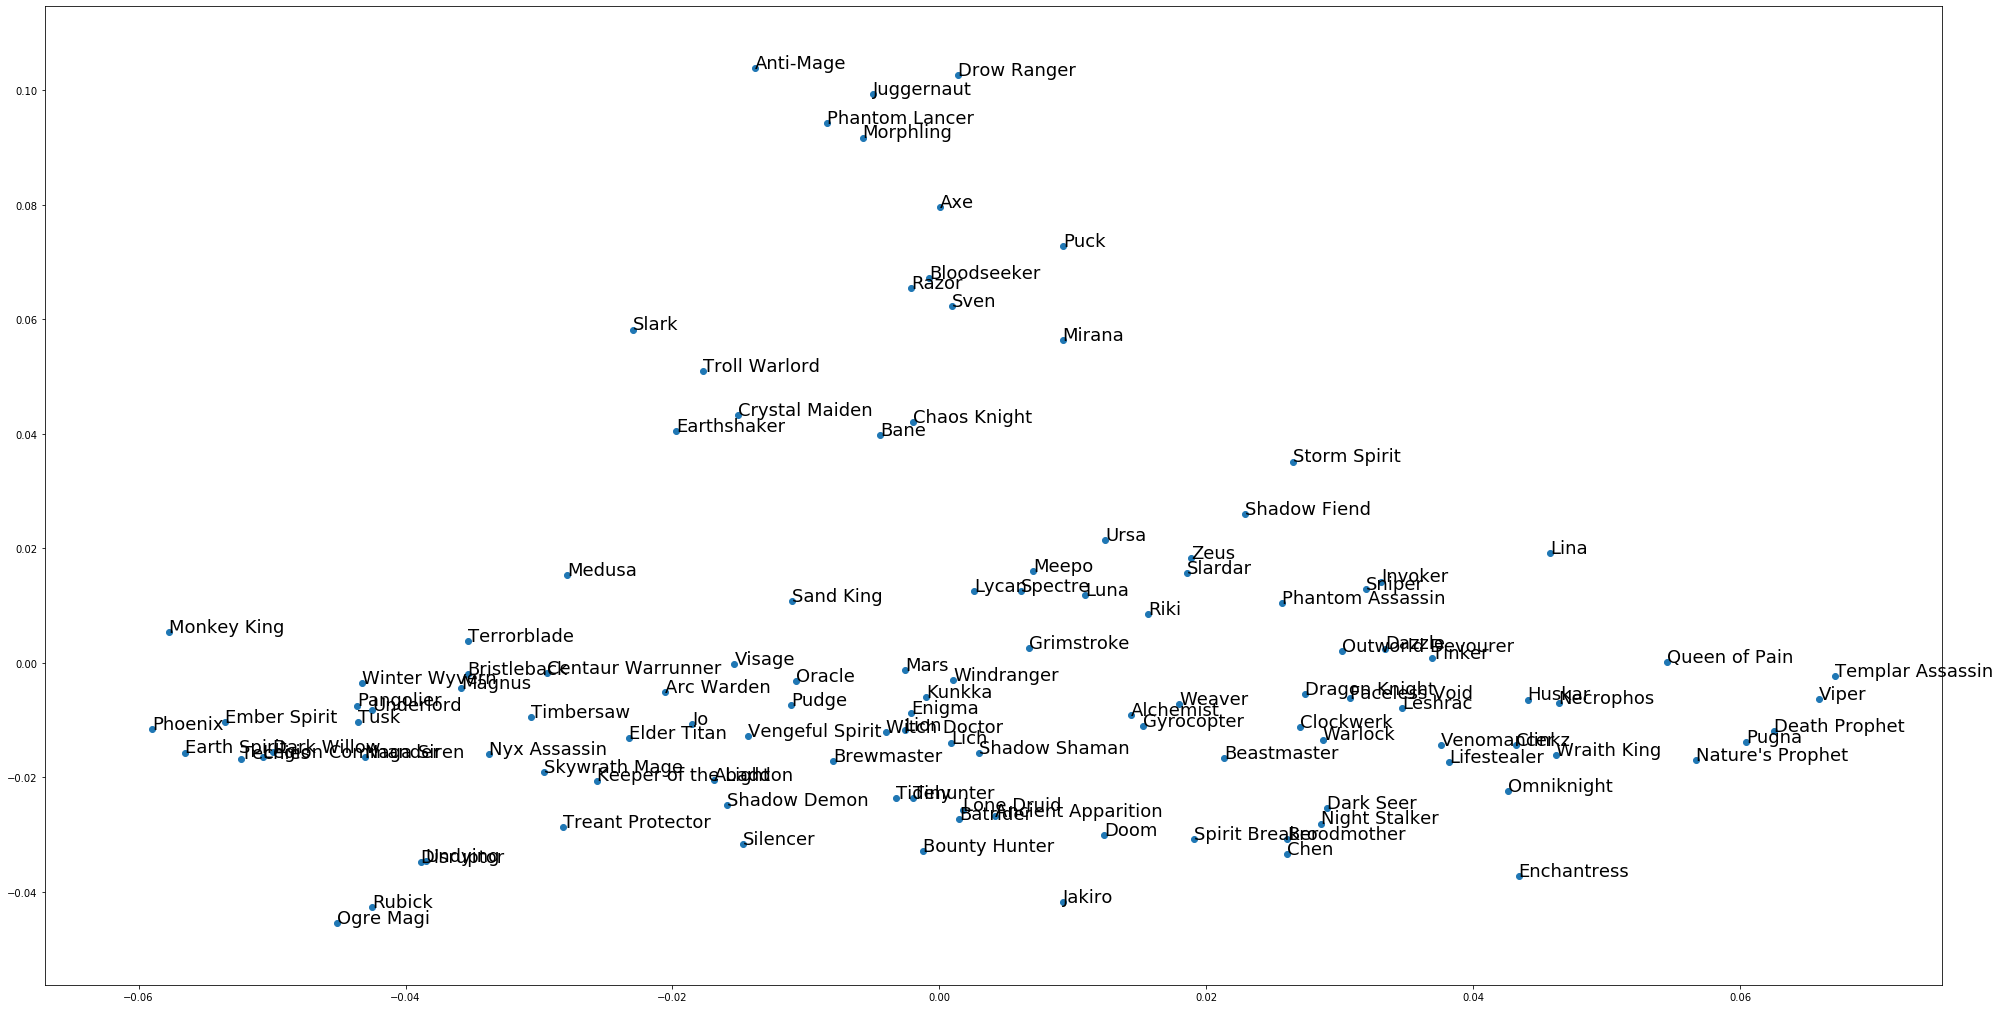

In [145]:
fig, ax = plt.subplots(figsize=(34, 18))
names = hero_ids['localized_name'].values
ax.scatter(clusters[:, 0], clusters[:, 1])
for i, c in enumerate(clusters):
    ax.annotate(names[i], (c[0], c[1]), size=18)

In [138]:
db = AgglomerativeClustering(10)
db_c = db.fit_predict(embeddings[:117])

In [139]:
db_c

array([9, 5, 5, 5, 5, 9, 5, 9, 9, 9, 8, 9, 8, 1, 9, 8, 1, 4, 2, 8, 1, 1,
       1, 1, 1, 8, 1, 8, 8, 8, 4, 8, 1, 1, 1, 6, 2, 1, 6, 4, 4, 6, 4, 6,
       6, 6, 4, 4, 6, 1, 6, 6, 4, 6, 4, 2, 2, 4, 4, 2, 1, 4, 2, 2, 2, 4,
       2, 2, 4, 2, 2, 2, 1, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 7, 7, 7, 7, 0, 7, 7, 8, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 1, 7], dtype=int64)

In [140]:
hero_ids['db_c'] = db_c

In [141]:
hero_ids.groupby('db_c').apply(lambda x: x.head(len(x)))

name       localized_name primary_attr  \
db_c id                                                                         
0    89            npc_dota_hero_naga_siren           Naga Siren          agi   
     90   npc_dota_hero_keeper_of_the_light  Keeper of the Light          int   
     91                  npc_dota_hero_wisp                   Io          str   
     92                npc_dota_hero_visage               Visage          int   
     93                 npc_dota_hero_slark                Slark          agi   
     94                npc_dota_hero_medusa               Medusa          agi   
     95         npc_dota_hero_troll_warlord        Troll Warlord          agi   
     96               npc_dota_hero_centaur    Centaur Warrunner          str   
     98              npc_dota_hero_shredder            Timbersaw          str   
     99           npc_dota_hero_bristleback          Bristleback          str   
     104     npc_dota_hero_legion_commander     Legion Commander          str   
1    14                 npc_dota_hero_pudge                Pudge          str   
     17          npc_dota_hero_storm_spirit         Storm Spirit          int   
     21            npc_dota_hero_windrunner           Windranger          int   
     22                  npc_dota_hero_zuus                 Zeus          int   
     23                npc_dota_hero_kunkka               Kunkka          str   
     25                  npc_dota_hero_lina                 Lina          int   
     26                  npc_dota_hero_lion                 Lion          int   
     28               npc_dota_hero_slardar              Slardar          str   
     34                npc_dota_hero_tinker               Tinker          int   
     35                npc_dota_hero_sniper               Sniper          agi   
     36             npc_dota_hero_necrolyte            Necrophos          int   
     39           npc_dota_hero_queenofpain        Queen of Pain          int   
     51            npc_dota_hero_rattletrap            Clockwerk          str   
     62         npc_dota_hero_bounty_hunter        Bounty Hunter          agi   
     74               npc_dota_hero_invoker              Invoker          int   
     121           npc_dota_hero_grimstroke           Grimstroke          int   
2    19                  npc_dota_hero_tiny                 Tiny          str   
     38           npc_dota_hero_beastmaster          Beastmaster          str   
     57            npc_dota_hero_omniknight           Omniknight          str   
     58           npc_dota_hero_enchantress          Enchantress          int   
     61           npc_dota_hero_broodmother          Broodmother          agi   
     64                npc_dota_hero_jakiro               Jakiro          int   
     65              npc_dota_hero_batrider             Batrider          int   
     66                  npc_dota_hero_chen                 Chen          int   
     68    npc_dota_hero_ancient_apparition   Ancient Apparition          int   
     69          npc_dota_hero_doom_bringer                 Doom          str   
     71        npc_dota_hero_spirit_breaker       Spirit Breaker          str   
     72            npc_dota_hero_gyrocopter           Gyrocopter          agi   
     73             npc_dota_hero_alchemist            Alchemist          str   
     77                 npc_dota_hero_lycan                Lycan          str   
     78            npc_dota_hero_brewmaster           Brewmaster          str   
     80            npc_dota_hero_lone_druid           Lone Druid          agi   
3    75              npc_dota_hero_silencer             Silencer          int   
     76    npc_dota_hero_obsidian_destroyer    Outworld Devourer          int   
     79          npc_dota_hero_shadow_demon         Shadow Demon          int   
     81          npc_dota_hero_chaos_knight         Chaos Knight          str   
     82                 npc_dota_hero_meepo                Meepo      

In [137]:
db.labels_

array([6, 4, 9, 6, 5, 0, 5, 0, 0, 0, 9, 7, 0, 3, 6, 3, 8, 0, 9, 9, 5, 5,
       9, 9, 5, 5, 5, 1, 5, 3, 5, 5, 9, 5, 5, 5, 5, 8, 9, 4, 8, 9, 4, 9,
       8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 1, 5, 9, 1, 9, 9, 2, 2, 2, 7,
       2, 2, 6, 1, 9, 9, 2, 3, 8, 1, 3, 3, 2, 7, 7, 2, 3, 6, 3, 5, 2, 3,
       2, 9, 6, 6, 6, 6, 9, 3, 1, 6, 3, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 0])